<a href="https://colab.research.google.com/github/martinzelikovsky/Scratch_Detection_CNN/blob/main/Scratch_Detection_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
# Get your Directory 
import os 
from zipfile import ZipFile

zipped = '/content/Scratch_Detection_CNN.zip'

with ZipFile(zipped, 'r') as zip:
  zip.extractall()
  print('Done')


directory = os.getcwd()
input_images = os.path.join(directory, 'Original Pictures')
validation_images = os.path.join(directory, 'Validation Images')
data_arrays = os.path.join(directory, 'Data_Arrays')
local_data_arrays = os.path.join(directory, 'drive/MyDrive/Data_Arrays')
model_path = os.path.join(directory, 'scratch_model.h5')
local_model_path = os.path.join(directory, 'drive/MyDrive/scratch_model.h5')
result_path = os.path.join(directory, 'Result')
local_result_path = os.path.join(directory, 'drive/MyDrive/Result')
unseen_images = os.path.join(directory, 'Unseen Test Images/image')
unseen_validation_images = os.path.join(directory, 'Unseen Test Images/mask')


if not os.path.exists(data_arrays):
  os.mkdir(data_arrays)
if not os.path.exists(local_data_arrays):
  os.mkdir(local_data_arrays)
if not os.path.exists(result_path):
  os.mkdir(result_path)
if not os.path.exists(local_result_path):
  os.mkdir(local_result_path)

In [ ]:
# CREATING DATASET
%tensorflow_version 1.x
import tensorflow
from __future__ import print_function
import  tensorflow.keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import cv2
import glob
import numpy as np
import random

PATCH_SIZE = 32 # Size of training image patches 32x32 pixels
TOTAL_NUMBER = 10000 # Number of Patches 

input_patches = [] # Input Patches 
output_patches = [] # Output Patches

input_patch_dir = os.path.join(data_arrays, 'input.npy')
output_patch_dir = os.path.join(data_arrays, 'output.npy')

local_input_patch_dir = os.path.join(data_arrays, 'input.npy')
local_output_patch_dir = os.path.join(data_arrays, 'output.npy')

file = open(input_patch_dir,"w+") # Create empty numpy array for input data
file.truncate(0)
file.close()

file = open(output_patch_dir,"w+") # Create empty numpy array for validation data
file.truncate(0)
file.close()

file = open(local_input_patch_dir,"w+") # Create empty numpy array for input data
file.truncate(0)
file.close()

file = open(local_output_patch_dir,"w+") # Create empty numpy array for validation data
file.truncate(0)
file.close()


filelist = glob.glob(validation_images + '/*') # list of all validation images used
for run, image_address in enumerate(filelist):
  binary_mask = cv2.imread(image_address, 0) # Validation image
  img_address = image_address.replace('Validation Images/label', 'Original Pictures/mlts') # Original Image Path
  input_image = cv2.imread(img_address, 0) # Original Image
  
  binary_mask[binary_mask > 10] = 255 # Cleaning up validation images to ensure binary values
  binary_mask[binary_mask <= 10] = 0

  row, col = binary_mask.shape
  x1 = []
  y1 = []
  x0 = []
  y0 = []

  # Gathering all indices with scratches in validation image 
  for i in range(16,row-16):
    for j in range(16,col-16):
      if binary_mask[i,j] == 255:
        x1.append(i)
        y1.append(j)
      else:
        x0.append(i)
        y0.append(j)
  

  for num_data in range(TOTAL_NUMBER):
    rand1 = random.randint(0,len(x1)-1)
    rand1_input_patch = input_image[(x1[rand1] - 16):(x1[rand1] + 16),(y1[rand1] - 16):(y1[rand1] + 16)] # finding a random 32x32 patch centered on a scratch pixel 

    rand0 = random.randint(0,len(x0)-1)
    rand0_input_patch = input_image[(x0[rand0] - 16):(x0[rand0] + 16),(y0[rand0] - 16):(y0[rand0] + 16)] # finding a random 32x32 patch centered on a non-scratch pixel 

    rand1_output = binary_mask[x1[rand1],y1[rand1]] # Scratch Pixel value 
    rand0_output = binary_mask[x0[rand0],y0[rand0]] # Non-Scratch Pixel value

  
    input_patches.append(rand0_input_patch) # append patch centered on non-scratch pixel 
    input_patches.append(rand1_input_patch) # append patch centered on scratch pixel 
    output_patches.append(rand0_output) # append non-scratch value
    output_patches.append(rand1_output) # append scratch value

    print('Number of data: ', num_data, 'Percent finished:', 100*run/len(filelist), '%') # progress
    
# convert patch lists to numpy arrays
  input_patches1 = np.array(input_patches)
  output_patches1 = np.array(output_patches)

# Save copy of training patch arrays
  np.save(input_patch_dir, input_patches1)
  np.save(output_patch_dir, output_patches1)

# Save local copy of training patch arrays
  np.save(local_input_patch_dir, input_patches1)
  np.save(local_output_patch_dir, output_patches1)

print("done")


In [ ]:
# Loads Data, creates CNN and trains the model 


from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import TensorBoard, ModelCheckpoint



batch_size = 32 # Small batch size
num_classes = 1 # Binary Classification 
epochs = 10 # Restore to 10
input_patch_dir = os.path.join(data_arrays, 'input.npy') # Patches from original images 
output_patch_dir = os.path.join(data_arrays, 'output.npy') # Patches from validation images 

def load_data():
    x = np.load(input_patch_dir)
    y = np.load(output_patch_dir)
    x = x.astype('float32') / 255. # normalize
    y = y.astype('float32') / 255. # normalize
    x = np.expand_dims(x, axis=-1)
    y = np.expand_dims(y, axis=-1)

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
    print(x_train.shape, x_val.shape)

    return x_train, x_val, y_train, y_val

x_train, x_val, y_train, y_val = load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')


model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', # 32 filters
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu')) # Rectified Linear Activation Function 
model.add(Conv2D(32, (3, 3))) # 32 filters
model.add(Activation('relu')) # Rectified Linear Activation Function
model.add(MaxPooling2D(pool_size=(2, 2))) # 2x2 Max Pooling layer 
model.add(Dropout(0.25)) # Dropout to avoid overfitting

model.add(Conv2D(64, (3, 3), padding='same')) # 64 filters
model.add(Activation('relu')) # Rectified Linear Activation Function
model.add(Conv2D(64, (3, 3))) # 64 filters
model.add(Activation('relu')) # Rectified Linear Activation Function
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25)) # Dropout to avoid overfitting

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu')) # Rectified Linear Activation Function
model.add(Dropout(0.5)) # Dropout to avoid overfitting
model.add(Dense(num_classes)) # Final binary Layer
model.add(Activation('sigmoid')) # Sigmoid activation layer 


opt = keras.optimizers.Adadelta() # Adadelta optimizer

model.compile(loss='binary_crossentropy', # Binary Crossentropy
              optimizer=opt,
              metrics=['binary_accuracy'])

model.summary()
plot_model(model, to_file='Scratch_Detection_Model.png')
tb_callback = TensorBoard(log_dir='./Graph_2', histogram_freq=0,
                          write_graph=True, write_images=True)

checkpoint = ModelCheckpoint(model_path, monitor='binary_crossentropy', verbose=1, save_best_only=True, mode='min')

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_val, y_val),
          shuffle=True)

# Save model
model.save(model_path)
model.save(local_model_path) 
print('Saved Trained model at {colab} and {local}'.format(colab=model_path, local=local_model_path))


# Score model
scores = model.evaluate(x_val, y_val, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



In [ ]:
# Tests the model by sending through Unseen Test Images
from keras import models  
import cv2
import numpy as np

for filee in glob.glob(unseen_images + '/*'):
  model = models.load_model(model_path)
  test = cv2.imread(filee,0)
  scratch = cv2.imread(filee,0)
  scratch = np.zeros_like(scratch)
  row,col = test.shape
  for i in range(16,row-16): # Model evaluates pixel by pixel (row pixels)
    for j in range(16,col-16): # Model evaluates pixel by pixel (column pixels)
      patch = test[i-16:i+16, j-16:j+16]
      patch = np.reshape(patch.astype('float32')/255, (1, patch.shape[0], patch.shape[1],1))
      prediction = model.predict(patch)
      prediction[prediction <= 0.5] = 0 # deemed not a scratch if prediction 0.5 or below
      prediction[prediction > 0.5] = 255 # deemed scratch if prediction above 0.5 
      prediction = prediction.astype('uint8')
      scratch[i,j] = prediction
    print('Progress:', 100*i/row, '% Finished', filee)
  file_num = filee[-5]
  cv2.imwrite('/content/drive/MyDrive/Result/scratch_10{}_new.png'.format(file_num),scratch) # Save local copy 
  cv2.imwrite('/content/Result/scratch_10{}_new.png'.format(file_num),scratch) # Save copy



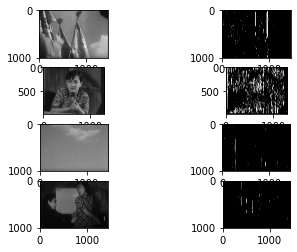

In [23]:
# plot Model inputs and outputs side by side 
import matplotlib.pyplot as plt

f, pos = plt.subplots(4,2)
for run, image in enumerate(glob.glob(result_path + '/*')):
  pos[run, 0].imshow(cv2.imread(image.replace('/Result/scratch', '/Unseen Test Images/image/mlts')))
  pos[run, 1].imshow(cv2.imread(image))
